In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
## data manupalitation and handling 
import pandas as pd
import numpy as np

# Data visualizatio libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

# Multicollinearity test and treatment Libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

## data preprocessing and EDA libraries 
from collections import OrderedDict 
from sklearn.preprocessing import StandardScaler

#Model Selection Libraries
from sklearn.model_selection import train_test_split , cross_val_score, GridSearchCV
 
#ML Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

#Model Evaluation Libraries
from sklearn.metrics import r2_score, mean_squared_error


# Warning filter library
import warnings
warnings.filterwarnings('ignore')

## loding the data frame

In [3]:
df=pd.read_excel("Capstone Project.xlsx")

In [4]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


## Build machine learning which will predict the strength of cement 
## problem statement :- we have to predict strength of the cement by studing this 8 independent columns

In [5]:
### exploratory data analysis (EDA)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


observation from df.info
1. Some of  are no null values 
2. 1030 rows & 9 coloums 
3. except age all the coloums data type is float 
4. Dependent variable is strength and rest are independent variable.

In [7]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


analysis from descriptive statistics

1. There might be skewness in the data in the columns.
2. There might be chance of outliers if we compare Quartiles of some of the columns.(age,cement,slag,superplastic,strength in the upper whisker region)
3. Since minimum and Q1 values are same for slag and ash we do not have outliers in the Lower Whisker region for them.
4. The range of values in age is from 1-365 we can say that the values in days.



In [8]:
df.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [9]:
def custom_summary(my_df):
    result = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            stats = OrderedDict({
                'Feature Name': col , 
                'Count': my_df[col].count() ,
                'Minimum': my_df[col].min() ,
                'Quartile1': my_df[col].quantile(.25) ,
                'Quartile2': my_df[col].quantile(.50) ,
                'Mean': my_df[col].mean() ,
                'Quartile 3': my_df[col].quantile(.75) ,
                'Maximum': my_df[col].max() ,
                'Variance': round(my_df[col].var()) ,
                'Standard Deviation': my_df[col].std() ,
                'Skewness': my_df[col].skew() , 
                'Kurtosis': my_df[col].kurt()
                })
            result.append(stats)
    result_df = pd.DataFrame(result)
    # skewness type
    skewness_label = []
    for i in result_df["Skewness"]:
        if i <= -1:
            skewness_label.append('Highly Negatively Skewed')
        elif -1 < i <= -0.5:
            skewness_label.append('Moderately Negatively Skewed')
        elif -0.5 < i < 0:
            skewness_label.append('Fairly Negatively Skewed')
        elif 0 <= i < 0.5:
            skewness_label.append('Fairly Positively Skewed')
        elif 0.5 <= i < 1:
            skewness_label.append('Moderately Positively Skewed')
        elif i >= 1:
            skewness_label.append('Highly Positively Skewed')
    result_df['Skewness Comment'] = skewness_label
    
    kurtosis_label=[]
    for i in result_df['Kurtosis']:
        if i >= 1:
            kurtosis_label.append('Leptokurtic Curve')
        elif i <= -1:
            kurtosis_label.append('Platykurtic Curve')
        else:
            kurtosis_label.append('Mesokurtic Curve')
    result_df['Kurtosis Comment'] = kurtosis_label
    Outliers_label = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            Q1 = my_df[col].quantile(0.25)
            Q2 = my_df[col].quantile(0.5)
            Q3 = my_df[col].quantile(0.75)
            IQR = Q3 - Q1
            LW = Q1 - 1.5*IQR
            UW = Q3 + 1.5*IQR
            if len(my_df[(my_df[col] < LW) | (my_df[col] > UW)]) > 0:
                Outliers_label.append('Have Outliers')
            else:
                Outliers_label.append('No Outliers')
    result_df['Outlier Comment'] = Outliers_label

            
    return result_df


    

    

In [10]:
custom_summary(df)

,Feature Name,Count,Minimum,Quartile1,Quartile2,Mean,Quartile 3,Maximum,Variance,Standard Deviation,Skewness,Kurtosis,Skewness Comment,Kurtosis Comment,Outlier Comment
0,cement,1030,102.00,192.375,272.900,281.167864,350.000,540.0,10922,104.506364,0.509481,-0.520652,Moderately Positively Skewed,Mesokurtic Curve,No Outliers
1,slag,1030,0.00,0.000,22.000,73.895825,142.950,359.4,7444,86.279342,0.800717,-0.508175,Moderately Positively Skewed,Mesokurtic Curve,Have Outliers
2,ash,1030,0.00,0.000,0.000,54.188350,118.300,200.1,4096,63.997004,0.537354,-1.328746,Moderately Positively Skewed,Platykurtic Curve,No Outliers
3,water,1030,121.80,164.900,185.000,181.567282,192.000,247.0,456,21.354219,0.074628,0.122082,Fairly Positively Skewed,Mesokurtic Curve,Have Outliers
4,superplastic,1030,0.00,0.000,6.400,6.204660,10.200,32.2,36,5.973841,0.907203,1.411269,Moderately Positively Skewed,Leptokurtic Curve,Have Outliers
5,coarseagg,1030,801.00,932.000,968.000,972.918932,1029.400,1145.0,6046,77.753954,-0.040220,-0.599016,Fairly Negatively Skewed,Mesokurtic Curve,No Outliers
6,fineagg,1030,594.00,730.950,779.500,773.580485,824.000,992.6,6428,80.175980,-0.253010,-0.102177,Fairly Negatively Skewed,Mesokurtic Curve,Have Outliers
7,age,1030,1.00,7.000,28.000,45.662136,56.000,365.0,3990,63.169912,3.269177,12.168989,Highly Positively Skewed,Leptokurtic Curve,Have Outliers
8,strength,1030,2.33,23.710,34.445,35.817961,46.135,82.6,279,16.705742,0.416977,-0.313725,Fairly Positively Skewed,Mesokurtic Curve,Have Outliers


 analysis from customs summary. 
    significance of Kurtosis: it gives us an idea about how good is mean and SD.
 1. Cement has a Mesokurtic curve which implies the data points are moderate in distance from the mean so mean and SD are moderate.
 2. slag has a Mesorkurtic curve which implies the data points are moderate in distance from the mean so mean and SD are moderate. 
 3. Ash has a Platykurtic curve which implies the mean doesnt represent the whole data properly so SD is high 
 4. Water has a Mesokurtic curve which implies the data poinys are moderate in distance from the mean so mean and SD are moderate 
 5. Superplastic has a Leptokurtic curve which implies data points are closer to the mean



In [11]:
def replace_outlier(my_df,col,method="Quartile",strategy="Median"):
    col_data = my_df[col] #method means how are you supposed to detect the outliers.
    
    if method == 'Quartile':
        #Using quartiles to calculate IQR
        q1 = col_data.quantile(0.25)
        q2 = col_data.quantile(0.5)
        q3 = col_data.quantile(0.75)

        IQR = q3 - q1
        LW = q1 - 1.5*IQR
        UW = q3 + 1.5*IQR
        
    elif method == 'Standard Deviation': #we are using empirical method here 
        mean = col_data.mean()
        std = col_data.std()
        LW = mean - 2*std
        UW = mean + 2*std
    else:
        print('Pass a correct method')
     
    ## printing all the outlier 
    outliers =  my_df.loc[(col_data < LW) | (col_data > UW)]
    outlier_density = round(len(outliers)/len(my_df) , 2) * 100 #What i am doing is, i am checking how many percentage of records are there which are outlier, so lets say if i have 15% are outliers so 15 % is my outliers density.
    if len(outliers) == 0:
        print(f'Feature {col} doesnot have any outliers')
        print('\n') #\n means next line
    else:
        print(f'Feature {col} Has outliers')
        print('\n')
        print(f'Total number of outliers in {col} are {len(outliers)}')
        print('\n')
        print(f'outlier percentage in {col} is {outlier_density}%')
        print('\n')
        display(my_df[(col_data < LW) | (col_data > UW)])
    
    ## Replacing outliers
    if strategy == 'Median':
        my_df.loc[(col_data < LW) | (col_data > UW) , col] = q2
    elif strategy == 'Mean':
         my_df.loc[(col_data < LW) | (col_data > UW) , col] = mean
    else:
        print('pass a correct strategy')
        
        
    return my_df

    
     


## ODT( outlier Detection  technique) plots 

1. Descriptive Plots
2. histogram with outliers
3. Histogram wihtout outliers

In [12]:
def odt_plots(my_df, col):
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,8))
    
    # Descriptive stats boxplot
    sns.boxplot(my_df[col] , ax = ax1)
    ax1.set_title(col + 'Boxplot')
    ax1.set_xlabel('values')
    ax1.set_ylabel('Boxplot')
    
    # Plotting histograms with outliers
    sns.distplot(my_df[col] , ax = ax2 , fit = sci.norm) # on histogram we are fitting normal distribution curve
    ax2.axvline(my_df[col].mean() , color = 'green')
    ax2.axvline(my_df[col].median() , color = 'brown')
    ax2.set_title(col + 'Histogram with outliers')
    ax2.set_ylabel('Density')
    ax2.set_xlabel('values')
    
    #replacing outliers 
    df_out = replace_outlier(my_df , col)
    
    #Plotting Histogram without outliers
    sns.distplot(df_out[col] , ax = ax3, fit =sci.norm) #On histogram i am fitting normal Distribution plot
    ax3.axvline(df_out[col].mean() , color = 'green')
    ax3.axvline(df_out[col].median() , color = 'brown')
    ax3.set_title(col + 'Histogram without outliers')
    ax3.set_ylabel('Density')
    ax3.set_xlabel('values')
    plt.show()


    
    

Feature cement doesnot have any outliers




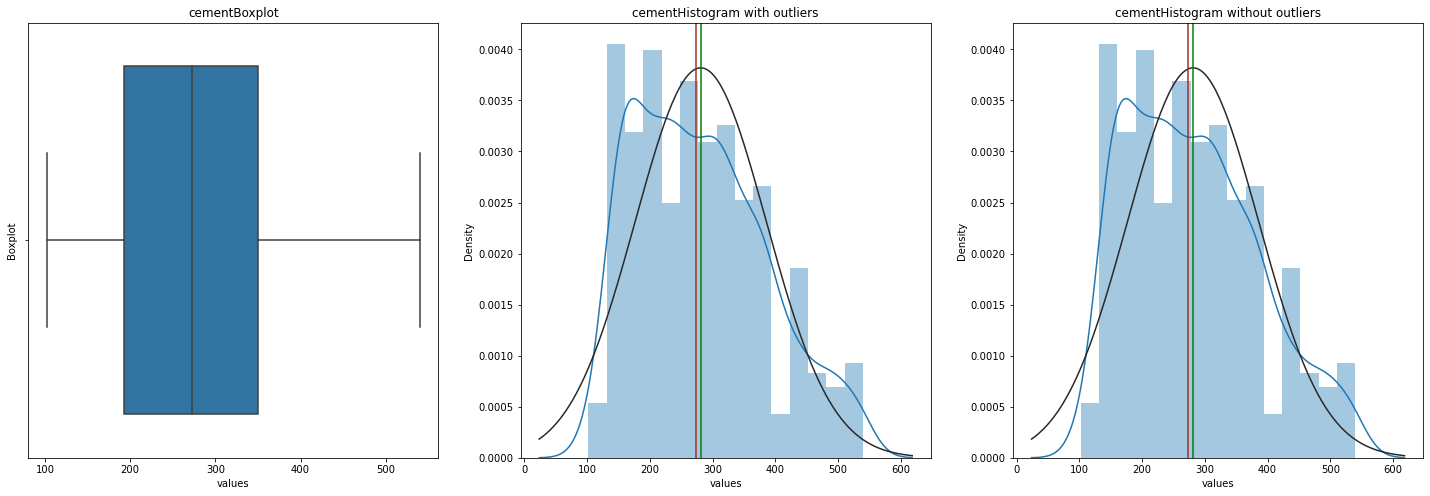

Feature slag Has outliers


Total number of outliers in slag are 2


outlier percentage in slag is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
918,239.6,359.4,0.0,185.7,0.0,941.6,664.3,28,39.44
990,239.6,359.4,0.0,185.7,0.0,941.6,664.3,7,25.42


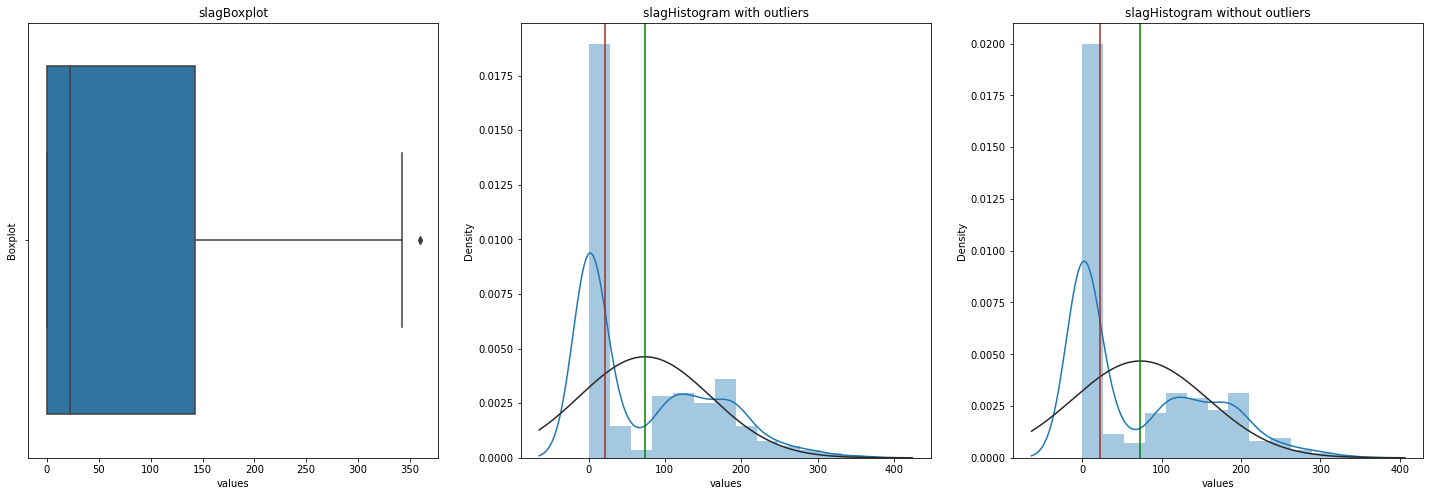

Feature ash doesnot have any outliers




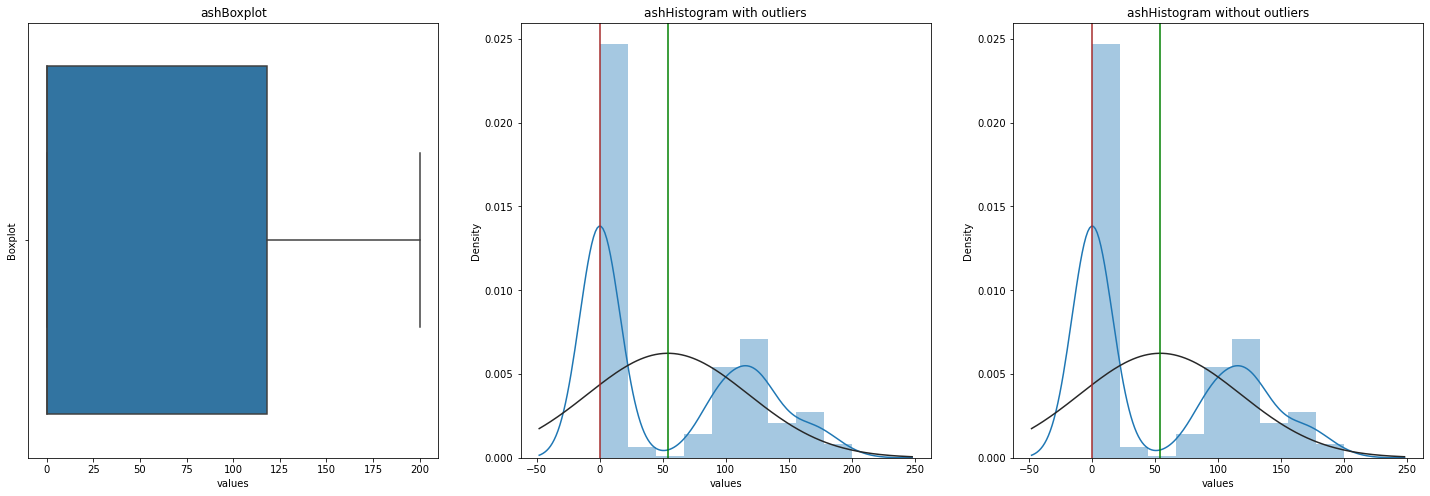

Feature water Has outliers


Total number of outliers in water are 9


outlier percentage in water is 1.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
66,237.0,92.0,71.0,247.0,6.0,853.0,695.0,28,28.63
263,236.9,91.7,71.5,246.9,6.0,852.9,695.4,28,28.63
432,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,28,24.24
462,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,100,39.23
587,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,3,7.75
740,140.0,164.0,128.0,237.0,6.0,869.0,656.0,28,35.23
789,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,56,32.85
826,139.7,163.9,127.7,236.7,5.8,868.6,655.6,28,35.23
914,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,14,17.82


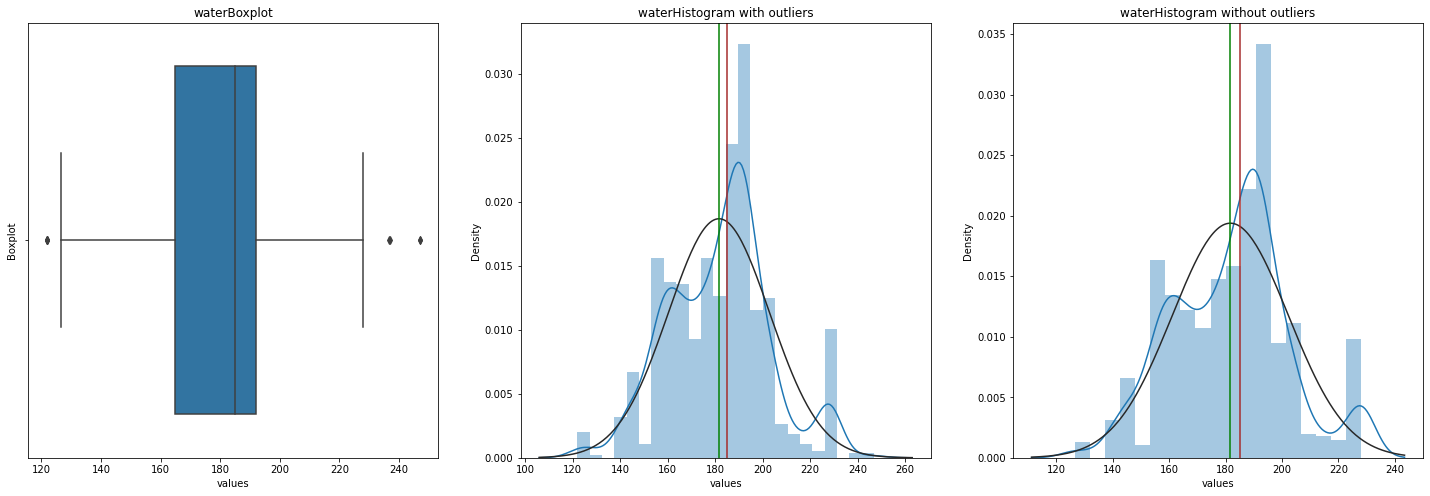

Feature superplastic Has outliers


Total number of outliers in superplastic are 10


outlier percentage in superplastic is 1.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91,59.2
156,531.3,0.0,0.0,141.8,28.2,852.1,893.7,28,56.4
232,469.0,117.2,0.0,137.8,32.2,852.1,840.5,56,69.3
292,469.0,117.2,0.0,137.8,32.2,852.1,840.5,91,70.7
538,531.3,0.0,0.0,141.8,28.2,852.1,893.7,7,46.9
744,469.0,117.2,0.0,137.8,32.2,852.1,840.5,7,54.9
816,469.0,117.2,0.0,137.8,32.2,852.1,840.5,28,66.9
838,531.3,0.0,0.0,141.8,28.2,852.1,893.7,56,58.8
955,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,40.2
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.3


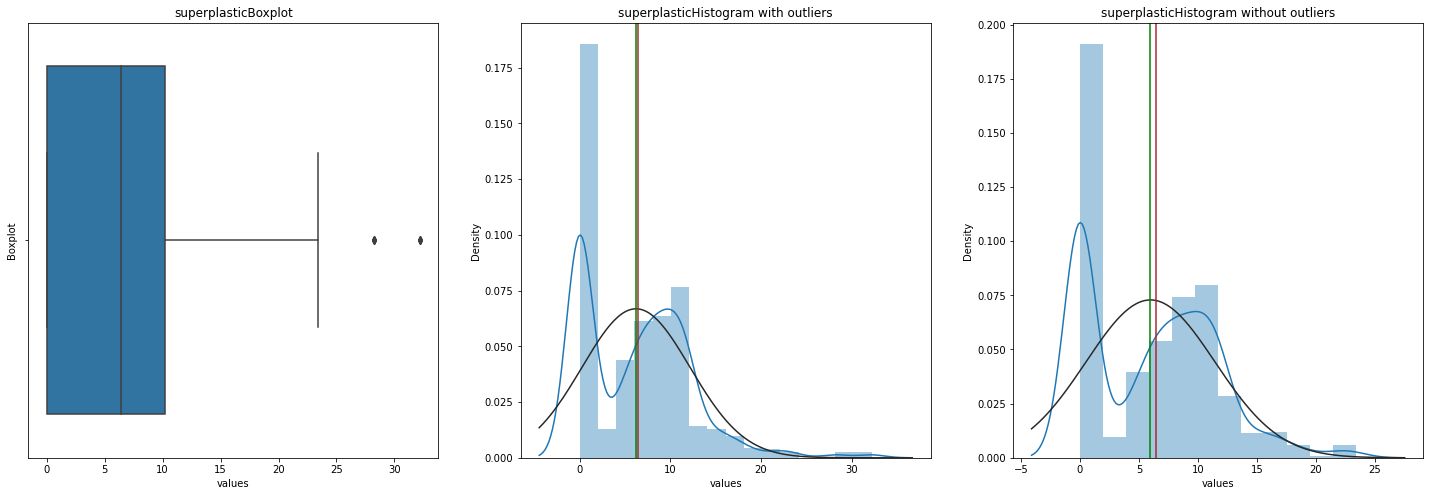

Feature coarseagg doesnot have any outliers




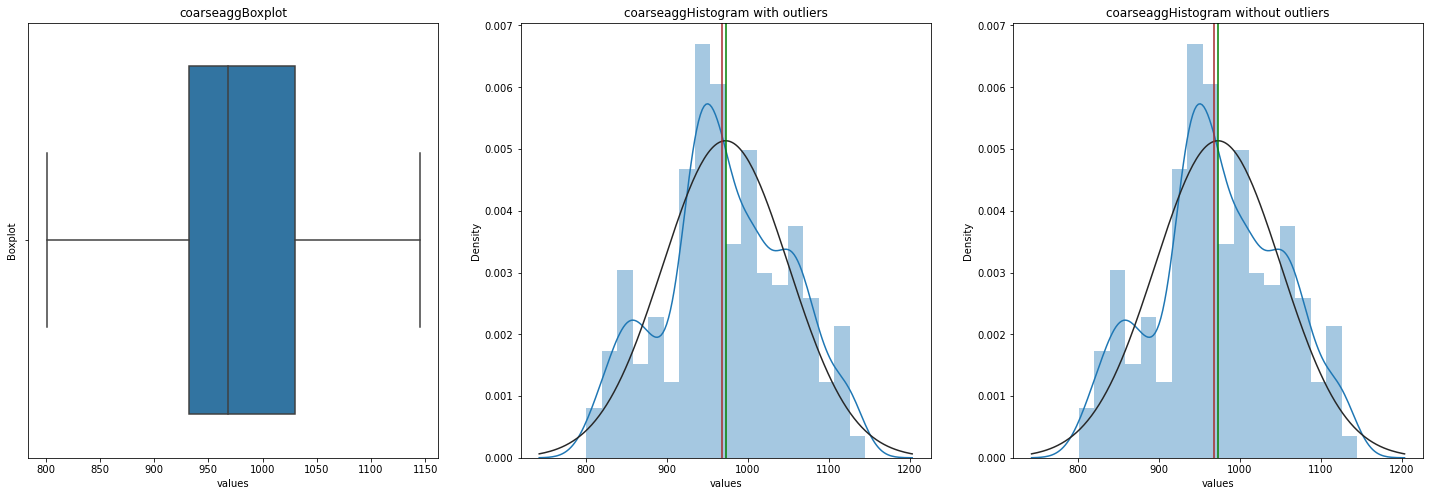

Feature fineagg Has outliers


Total number of outliers in fineagg are 5


outlier percentage in fineagg is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
129,375.0,93.8,0.0,126.6,23.4,852.1,992.6,91,62.5
447,375.0,93.8,0.0,126.6,23.4,852.1,992.6,7,45.7
504,375.0,93.8,0.0,126.6,23.4,852.1,992.6,3,29.0
584,375.0,93.8,0.0,126.6,23.4,852.1,992.6,56,60.2
857,375.0,93.8,0.0,126.6,23.4,852.1,992.6,28,56.7


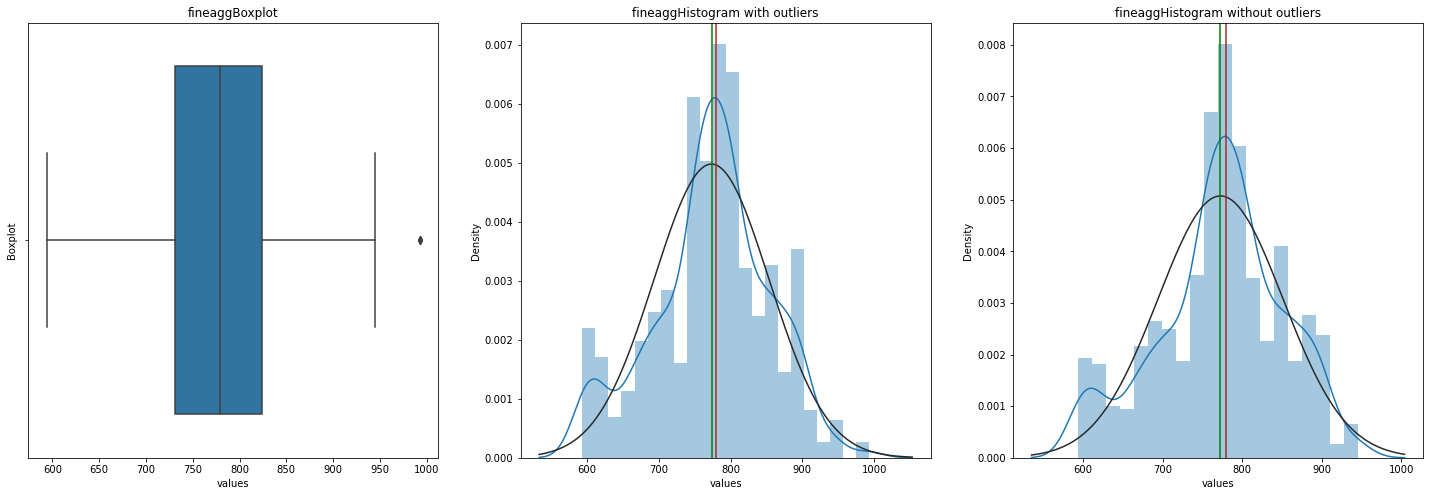

Feature age Has outliers


Total number of outliers in age are 59


outlier percentage in age is 6.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
51,331.0,0.0,0.0,192.0,0.0,978.0,825.0,180,39.00
64,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
93,427.5,47.5,0.0,228.0,0.0,932.0,594.0,180,41.84
99,237.5,237.5,0.0,228.0,0.0,932.0,594.0,180,36.25
103,380.0,0.0,0.0,228.0,0.0,932.0,670.0,180,53.10
133,236.0,0.0,0.0,193.0,0.0,968.0,885.0,365,25.08
144,302.0,0.0,0.0,203.0,0.0,974.0,817.0,180,26.74
149,380.0,95.0,0.0,228.0,0.0,932.0,594.0,270,41.15
152,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,29.59
157,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


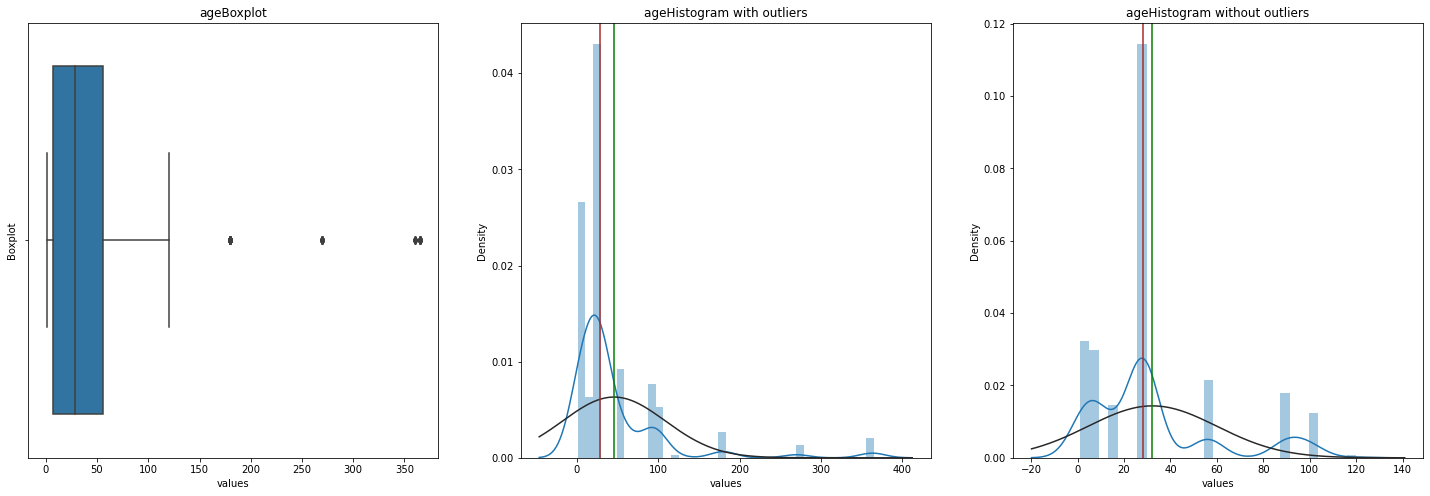

Feature strength Has outliers


Total number of outliers in strength are 4


outlier percentage in strength is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
192,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28,81.75
732,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
950,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91,82.60
1003,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56,80.20


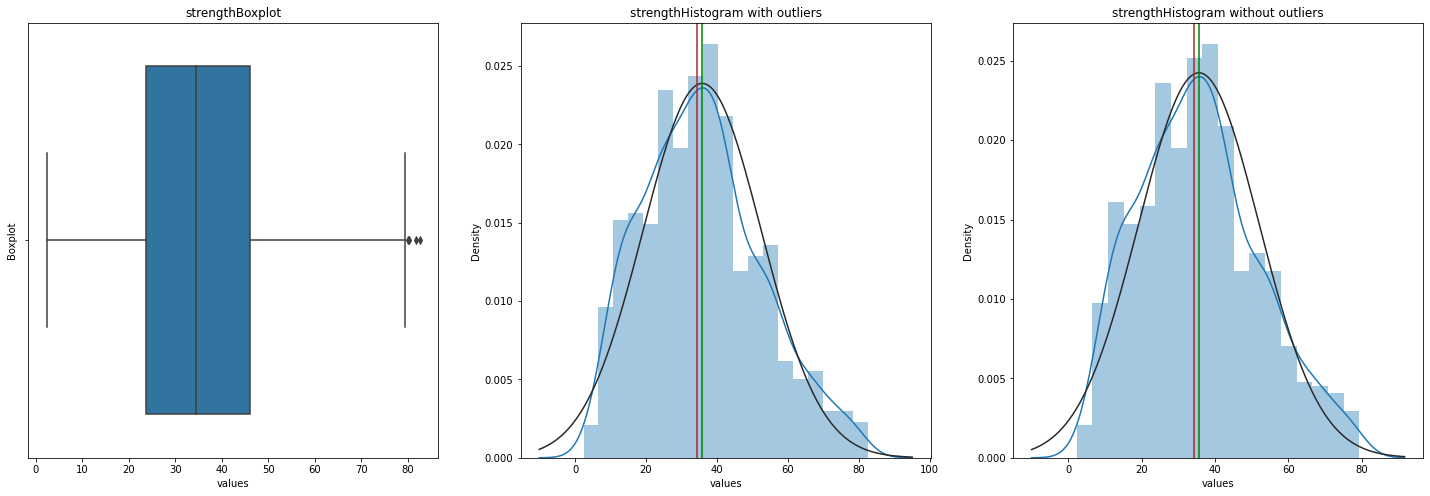

In [13]:
for col in df.columns:
    odt_plots(df, col)

## Multivariate analysis using regression


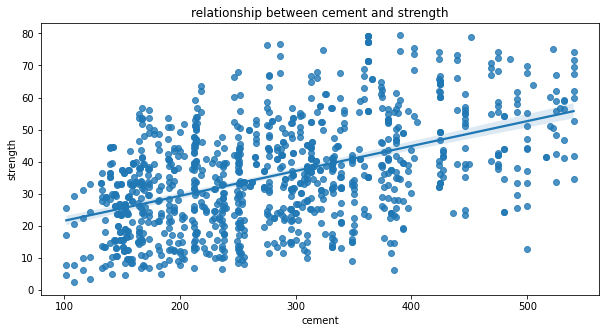

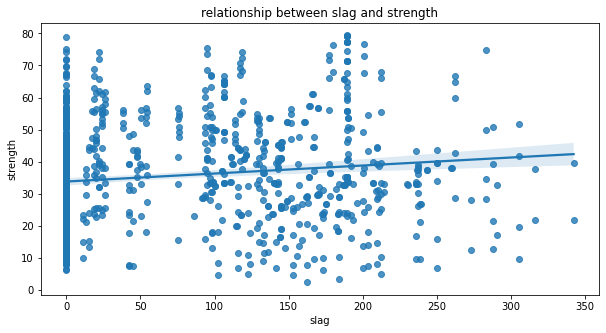

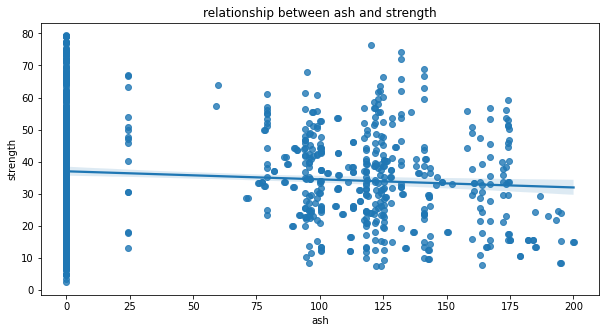

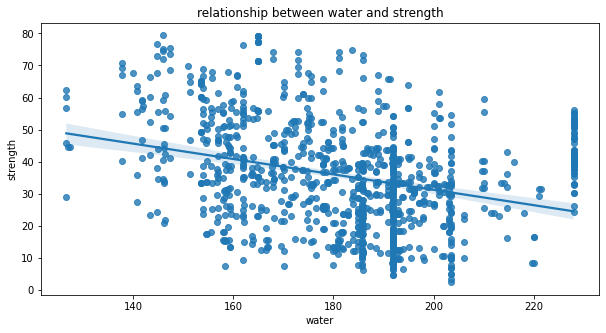

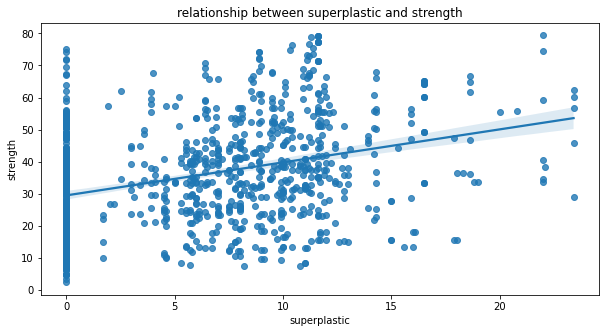

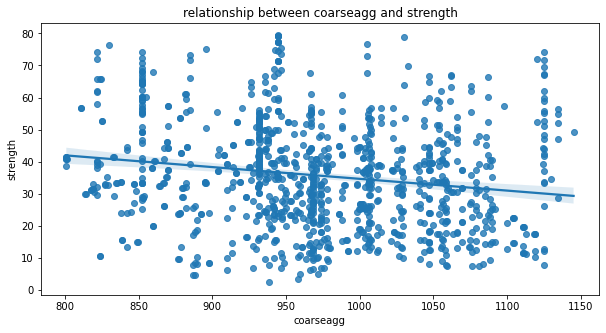

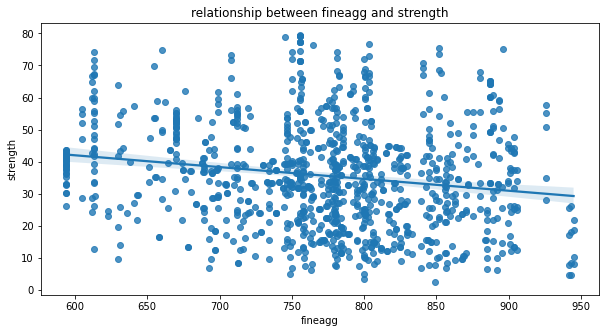

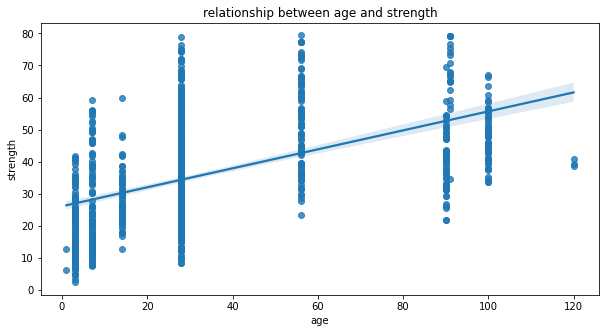

In [14]:
for col in df.columns:
    if col != 'strength':
        fig, ax1 = plt.subplots(figsize = (10,5))
        sns.regplot(x = df[col] , y = df['strength'] , ax = ax1).set_title(f'relationship between {col} and strength')
    

Analysis from Regression plots:

1. Strength and cement are highly positively correlated.
2. Strength and slag are slightly positively correlated.
3. Strength and ash are slightly negatively correlated.
4. Strength and water are highly negatively correlated.
5. Superplastic and stength are highly postively correlated.
6. Coarseegg and strength are slightly negatively correlated.
7. fineegg and strength are highly negatively correlated.
8. Age and strength are highly positively correlated.


## Mulitcollinearity Test

- Correlation Matrix/Heatmap (stage 1)

<AxesSubplot:>

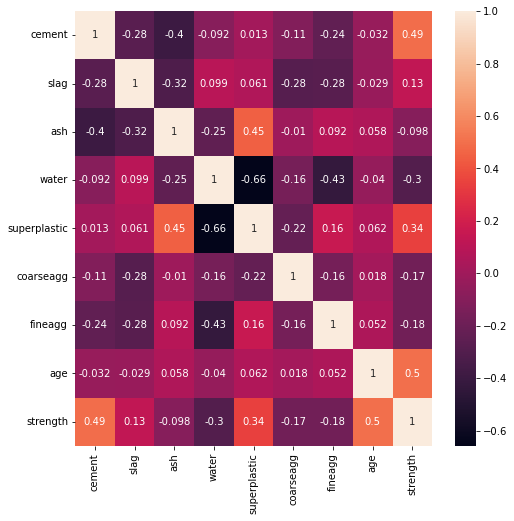

In [15]:
corr = df.corr()
df.ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr, annot = True)

Analysis / Results from stage 1 test:

1. Slag has high correlation with ash
2. ash has high correaltion with cement, superplastics
3. water has high correaltion with superplastics, fineagg
4. Superplastic has high correlation with ash, water

- Many feature have correaltion more than 30% so we can conclude stage 1 results, that there is a chance of multicollinearity.

-- Multicollinearity Test (stage 2)

 - variance Inflation factor( VIF) Formula for VIF = 1/ (1-R2)
 
 steps:
 1. Regress every independent variable with each other and calculate R2
 2. Find VIF using above formula
 3. If VIF is more than 5, we say that multicollinearity exists.

In [16]:
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif['features'] = dataset.columns
    vif['VIF_Values'] = [variance_inflation_factor(dataset.values,i) for i in range(dataset.shape[1])]
    vif['VIF_Values'] = round(vif['VIF_Values'] , 2)
    vif = vif.sort_values(by = 'VIF_Values' , ascending = False)
    return (vif)
    

In [17]:
calculate_vif(df.drop('strength' , axis = 1))

,features,VIF_Values
5,coarseagg,86.94
3,water,81.96
6,fineagg,68.66
0,cement,14.29
4,superplastic,5.72
2,ash,4.42
1,slag,3.34
7,age,2.37


## Correlation with the target feature

In [18]:
def correlation_with_target(data, t_col):
    independent_variable = data.drop(t_col , axis = 1).columns
    corr_result = []
    for col in independent_variable:
        corr_result.append(data[t_col].corr(data[col]))
    result = pd.DataFrame([independent_variable , corr_result], index = ['Independent vairbales' , 'Correlation']).T
    return result.sort_values('Correlation' , ascending = False)
    

In [19]:
correlation_with_target(df, 'strength')

,Independent vairbales,Correlation
7,age,0.499711
0,cement,0.493518
4,superplastic,0.342633
1,slag,0.129561
2,ash,-0.097973
5,coarseagg,-0.173234
6,fineagg,-0.176113
3,water,-0.300043


Analysis :
1. Age  have a 53% correlation with strength
2. Cement have 49% correlation with strength.
3. Superplastic and water have 32% and 30% correlation with strength.

## Model Building
- Stages of model building
- Custom train-test-split Function
- Cross -validation
- Hyperparameter Tuning

In [20]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df.drop(columns=['strength'])
y = df['strength']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of the train and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (721, 8) (721,)
Test set shape: (309, 8) (309,)


In [21]:
def correlation_with_target(df, t_col):
    independent_variable = df.drop(t_col , axis = 1).columns
    corr_result = []
    for col in independent_variable:
        corr_result.append(df[t_col].corr(df[col]))
    result = pd.DataFrame([independent_variable , corr_result], index = ['Independent vairbales' , 'Correlation']).T
    return result.sort_values('Correlation' , ascending = False)
    

In [22]:
correlation_with_target(df, 'strength')

,Independent vairbales,Correlation
7,age,0.499711
0,cement,0.493518
4,superplastic,0.342633
1,slag,0.129561
2,ash,-0.097973
5,coarseagg,-0.173234
6,fineagg,-0.176113
3,water,-0.300043


In [23]:
def model_builder(model_name, model, df, t_col):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    result = [model_name, rmse, r2]
    return result

In [24]:
def multiple_models(df, t_col):
    col_names = ['Model Name' , 'RMSE' , 'R2 Score']
    result = pd.DataFrame(columns = col_names)
    result.loc[len(result)] = model_builder('LinearRegression' , LinearRegression() , df , t_col)
    result.loc[len(result)] = model_builder('Lasso' , Lasso() , df , t_col)
    result.loc[len(result)] = model_builder('Ridge' , Ridge() , df , t_col)
    result.loc[len(result)] = model_builder('DTR' , DecisionTreeRegressor() , df , t_col)
    result.loc[len(result)] = model_builder('SVR' , SVR() , df , t_col)
    result.loc[len(result)] = model_builder('Random Forest' , RandomForestRegressor() , df , t_col)
    result.loc[len(result)] = model_builder('KNN' , KNeighborsRegressor() , df , t_col)
    result.loc[len(result)] = model_builder('Gboost' , GradientBoostingRegressor() , df , t_col)
    result.loc[len(result)] = model_builder('XGboost' , XGBRegressor() , df , t_col)
    result.loc[len(result)] = model_builder('Adaboost' , AdaBoostRegressor() , df , t_col)

    return result.sort_values('R2 Score' , ascending = False)
    

In [25]:
multiple_models(df , 'strength')

,Model Name,RMSE,R2 Score
5,Random Forest,5.863647,0.860032
8,XGboost,6.290767,0.838898
7,Gboost,6.859698,0.808441
3,DTR,7.578085,0.766218
9,Adaboost,7.725260,0.757049
1,Lasso,9.177607,0.657113
2,Ridge,9.203381,0.655184
0,LinearRegression,9.203395,0.655183
6,KNN,10.094383,0.585187
4,SVR,13.728560,0.232740


In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Create an XGBoost regressor
model = xgb.XGBRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
top_features = feature_importances_df.nlargest(3, 'Importance')

# Print the top 3 features
print(top_features)

# Print the evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)


  Feature  Importance
0  cement    0.253585
7     age    0.246034
1    slag    0.187837
Root Mean Squared Error (RMSE): 6.290766857171548
R-squared: 0.8388984550425286


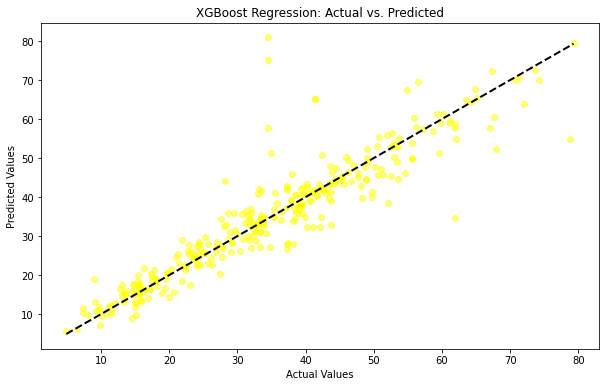

In [27]:
import matplotlib.pyplot as plt

# Plotting the actual values and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c='yellow', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Regression: Actual vs. Predicted")
plt.show()


In [28]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest regressor
model_rf = RandomForestRegressor()

# Fit the model on the training data
model_rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = model_rf.predict(X_test)

# Calculate evaluation metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Get feature importances
feature_importances_rf = model_rf.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importances_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_rf})

# Sort the features by importance in descending order
top_features_rf = feature_importances_df_rf.nlargest(3, 'Importance')

# Print the top 3 features
print(top_features_rf)

# Print the evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("R-squared:", r2_rf)


  Feature  Importance
0  cement    0.331268
7     age    0.324246
3   water    0.114438
Root Mean Squared Error (RMSE): 5.852903206665031
R-squared: 0.8605446406434933


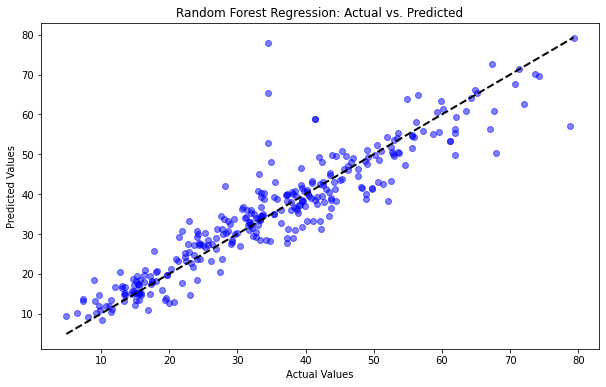

In [29]:
# Plotting the actual values and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, c='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regression: Actual vs. Predicted")
plt.show()


In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Create a Gradient Boosting regressor
model = GradientBoostingRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
top_features = feature_importances_df.nlargest(3, 'Importance')

# Print the top 3 features
print(top_features)


# Print the evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)

  Feature  Importance
7     age    0.345783
0  cement    0.323856
3   water    0.109002
Root Mean Squared Error (RMSE): 6.807700713912821
R-squared: 0.8113340900623615


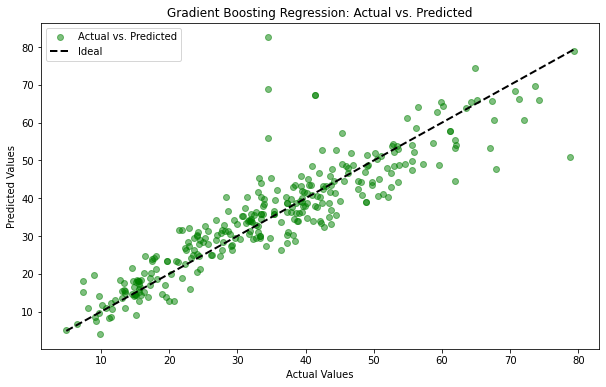

In [31]:
import matplotlib.pyplot as plt

# Plotting the actual values and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c='green', alpha=0.5, label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Gradient Boosting Regression: Actual vs. Predicted")
plt.legend()
plt.show()

In [32]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest regressor
model_rf = RandomForestRegressor()

# Fit the model on the training data
model_rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = model_rf.predict(X_test)

# Calculate evaluation metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Get feature importances
feature_importances_rf = model_rf.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importances_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_rf})

# Sort the features by importance in descending order
top_features_rf = feature_importances_df_rf.nlargest(3, 'Importance')

# Print the top 3 features
print(top_features_rf)

# Print the evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("R-squared:", r2_rf)


  Feature  Importance
7     age    0.322225
0  cement    0.317478
3   water    0.117776
Root Mean Squared Error (RMSE): 5.8261033503104915
R-squared: 0.8618188209655536


#### Using test data to predict the values 

In [33]:
df=pd.read_csv("Capstone project test.csv")

In [34]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,152.0,0.0,112.0,184.0,8.0,992.0,816.0,28
1,213.8,98.1,24.5,181.7,6.7,1066.0,785.5,3
2,152.7,144.7,0.0,178.1,8.0,999.7,822.2,28
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,7
4,222.4,0.0,96.7,189.3,4.5,967.1,870.3,3


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        199 non-null    float64
 1   slag          199 non-null    float64
 2   ash           199 non-null    float64
 3   water         199 non-null    float64
 4   superplastic  199 non-null    float64
 5   coarseagg     199 non-null    float64
 6   fineagg       199 non-null    float64
 7   age           199 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [36]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,289.258291,76.631658,56.731156,178.355276,7.211558,964.386935,776.563819,42.150754
std,101.376517,83.756459,65.439215,21.791940,6.199073,76.990501,79.324553,59.889691
min,108.300000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000
25%,212.050000,0.000000,0.000000,160.700000,0.000000,920.100000,742.500000,7.000000
50%,295.700000,26.000000,0.000000,178.000000,8.000000,967.000000,780.700000,28.000000
75%,362.600000,145.000000,121.600000,192.000000,11.000000,1023.900000,827.750000,28.000000
max,540.000000,359.400000,200.100000,236.700000,32.200000,1134.300000,992.600000,365.000000


In [37]:
def custom_summary(my_df):
    result = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            stats = OrderedDict({
                'Feature Name': col , 
                'Count': my_df[col].count() ,
                'Minimum': my_df[col].min() ,
                'Quartile1': my_df[col].quantile(.25) ,
                'Quartile2': my_df[col].quantile(.50) ,
                'Mean': my_df[col].mean() ,
                'Quartile 3': my_df[col].quantile(.75) ,
                'Maximum': my_df[col].max() ,
                'Variance': round(my_df[col].var()) ,
                'Standard Deviation': my_df[col].std() ,
                'Skewness': my_df[col].skew() , 
                'Kurtosis': my_df[col].kurt()
                })
            result.append(stats)
    result_df = pd.DataFrame(result)
    # skewness type
    skewness_label = []
    for i in result_df["Skewness"]:
        if i <= -1:
            skewness_label.append('Highly Negatively Skewed')
        elif -1 < i <= -0.5:
            skewness_label.append('Moderately Negatively Skewed')
        elif -0.5 < i < 0:
            skewness_label.append('Fairly Negatively Skewed')
        elif 0 <= i < 0.5:
            skewness_label.append('Fairly Positively Skewed')
        elif 0.5 <= i < 1:
            skewness_label.append('Moderately Positively Skewed')
        elif i >= 1:
            skewness_label.append('Highly Positively Skewed')
    result_df['Skewness Comment'] = skewness_label
    
    kurtosis_label=[]
    for i in result_df['Kurtosis']:
        if i >= 1:
            kurtosis_label.append('Leptokurtic Curve')
        elif i <= -1:
            kurtosis_label.append('Platykurtic Curve')
        else:
            kurtosis_label.append('Mesokurtic Curve')
    result_df['Kurtosis Comment'] = kurtosis_label
    Outliers_label = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            Q1 = my_df[col].quantile(0.25)
            Q2 = my_df[col].quantile(0.5)
            Q3 = my_df[col].quantile(0.75)
            IQR = Q3 - Q1
            LW = Q1 - 1.5*IQR
            UW = Q3 + 1.5*IQR
            if len(my_df[(my_df[col] < LW) | (my_df[col] > UW)]) > 0:
                Outliers_label.append('Have Outliers')
            else:
                Outliers_label.append('No Outliers')
    result_df['Outlier Comment'] = Outliers_label

            
    return result_df


    

    

In [38]:
custom_summary(df)

,Feature Name,Count,Minimum,Quartile1,Quartile2,Mean,Quartile 3,Maximum,Variance,Standard Deviation,Skewness,Kurtosis,Skewness Comment,Kurtosis Comment,Outlier Comment
0,cement,199,108.3,212.05,295.7,289.258291,362.60,540.0,10277,101.376517,0.283494,-0.704108,Fairly Positively Skewed,Mesokurtic Curve,No Outliers
1,slag,199,0.0,0.00,26.0,76.631658,145.00,359.4,7015,83.756459,0.726808,-0.289122,Moderately Positively Skewed,Mesokurtic Curve,No Outliers
2,ash,199,0.0,0.00,0.0,56.731156,121.60,200.1,4282,65.439215,0.502669,-1.347413,Moderately Positively Skewed,Platykurtic Curve,No Outliers
3,water,199,121.8,160.70,178.0,178.355276,192.00,236.7,475,21.791940,0.221432,0.092986,Fairly Positively Skewed,Mesokurtic Curve,No Outliers
4,superplastic,199,0.0,0.00,8.0,7.211558,11.00,32.2,38,6.199073,0.933630,1.975194,Moderately Positively Skewed,Leptokurtic Curve,Have Outliers
5,coarseagg,199,801.0,920.10,967.0,964.386935,1023.90,1134.3,5928,76.990501,-0.089391,-0.656580,Fairly Negatively Skewed,Mesokurtic Curve,No Outliers
6,fineagg,199,594.0,742.50,780.7,776.563819,827.75,992.6,6292,79.324553,-0.475969,0.099089,Fairly Negatively Skewed,Mesokurtic Curve,Have Outliers
7,age,199,1.0,7.00,28.0,42.150754,28.00,365.0,3587,59.889691,3.457862,13.863643,Highly Positively Skewed,Leptokurtic Curve,Have Outliers


In [39]:
def replace_outlier(my_df,col,method="Quartile",strategy="Median"):
    col_data = my_df[col] #method means how are you supposed to detect the outliers.
    
    if method == 'Quartile':
        #Using quartiles to calculate IQR
        q1 = col_data.quantile(0.25)
        q2 = col_data.quantile(0.5)
        q3 = col_data.quantile(0.75)

        IQR = q3 - q1
        LW = q1 - 1.5*IQR
        UW = q3 + 1.5*IQR
        
    elif method == 'Standard Deviation': #we are using empirical method here 
        mean = col_data.mean()
        std = col_data.std()
        LW = mean - 2*std
        UW = mean + 2*std
    else:
        print('Pass a correct method')
     
    ## printing all the outlier 
    outliers =  my_df.loc[(col_data < LW) | (col_data > UW)]
    outlier_density = round(len(outliers)/len(my_df) , 2) * 100 #What i am doing is, i am checking how many percentage of records are there which are outlier, so lets say if i have 15% are outliers so 15 % is my outliers density.
    if len(outliers) == 0:
        print(f'Feature {col} doesnot have any outliers')
        print('\n') #\n means next line
    else:
        print(f'Feature {col} Has outliers')
        print('\n')
        print(f'Total number of outliers in {col} are {len(outliers)}')
        print('\n')
        print(f'outlier percentage in {col} is {outlier_density}%')
        print('\n')
        display(my_df[(col_data < LW) | (col_data > UW)])
    
    ## Replacing outliers
    if strategy == 'Median':
        my_df.loc[(col_data < LW) | (col_data > UW) , col] = q2
    elif strategy == 'Mean':
         my_df.loc[(col_data < LW) | (col_data > UW) , col] = mean
    else:
        print('pass a correct strategy')
        
        
    return my_df

    
     


In [40]:
def odt_plots(my_df, col):
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,8))
    
    # Descriptive stats boxplot
    sns.boxplot(my_df[col] , ax = ax1)
    ax1.set_title(col + 'Boxplot')
    ax1.set_xlabel('values')
    ax1.set_ylabel('Boxplot')
    
    # Plotting histograms with outliers
    sns.distplot(my_df[col] , ax = ax2 , fit = sci.norm) # on histogram we are fitting normal distribution curve
    ax2.axvline(my_df[col].mean() , color = 'green')
    ax2.axvline(my_df[col].median() , color = 'brown')
    ax2.set_title(col + 'Histogram with outliers')
    ax2.set_ylabel('Density')
    ax2.set_xlabel('values')
    
    #replacing outliers 
    df_out = replace_outlier(my_df , col)
    
    #Plotting Histogram without outliers
    sns.distplot(df_out[col] , ax = ax3, fit =sci.norm) #On histogram i am fitting normal Distribution plot
    ax3.axvline(df_out[col].mean() , color = 'green')
    ax3.axvline(df_out[col].median() , color = 'brown')
    ax3.set_title(col + 'Histogram without outliers')
    ax3.set_ylabel('Density')
    ax3.set_xlabel('values')
    plt.show()


    
    

Feature cement doesnot have any outliers




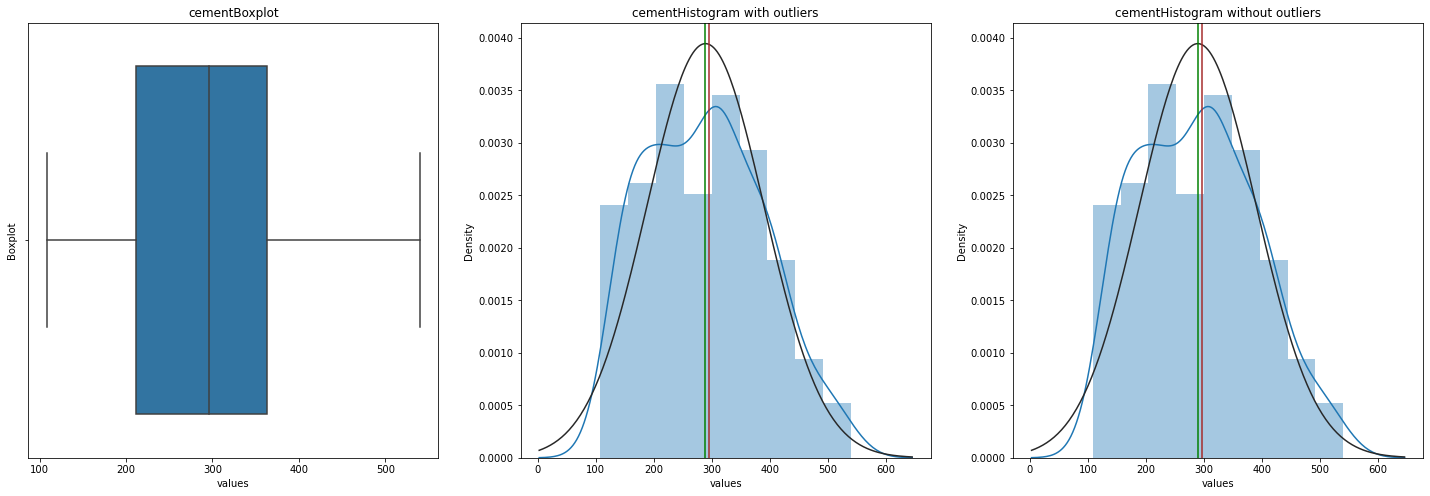

Feature slag doesnot have any outliers




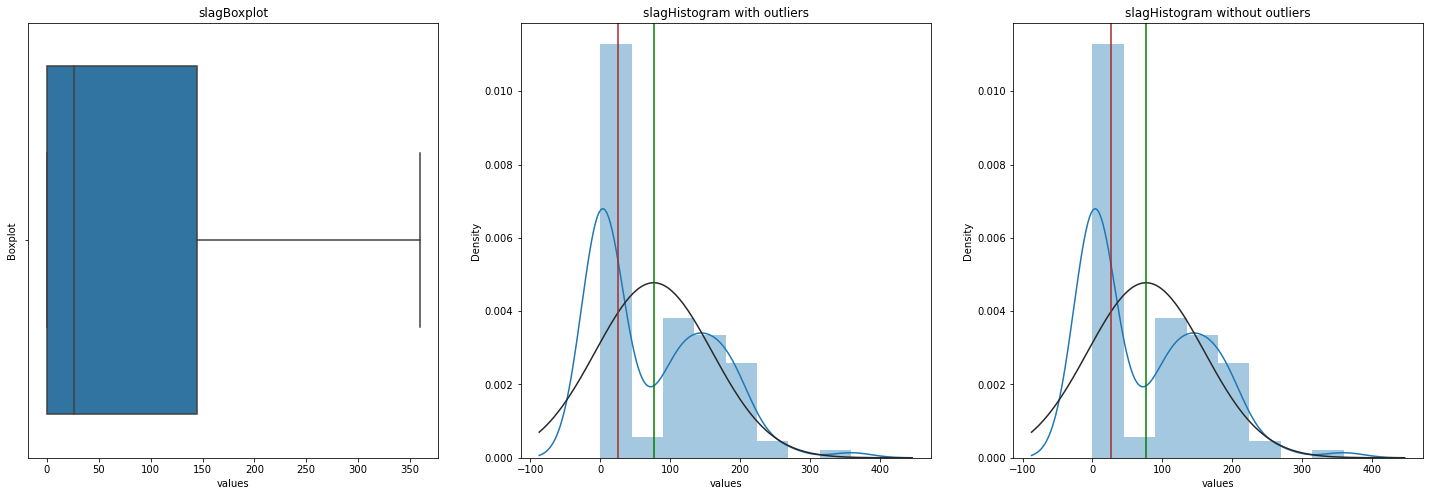

Feature ash doesnot have any outliers




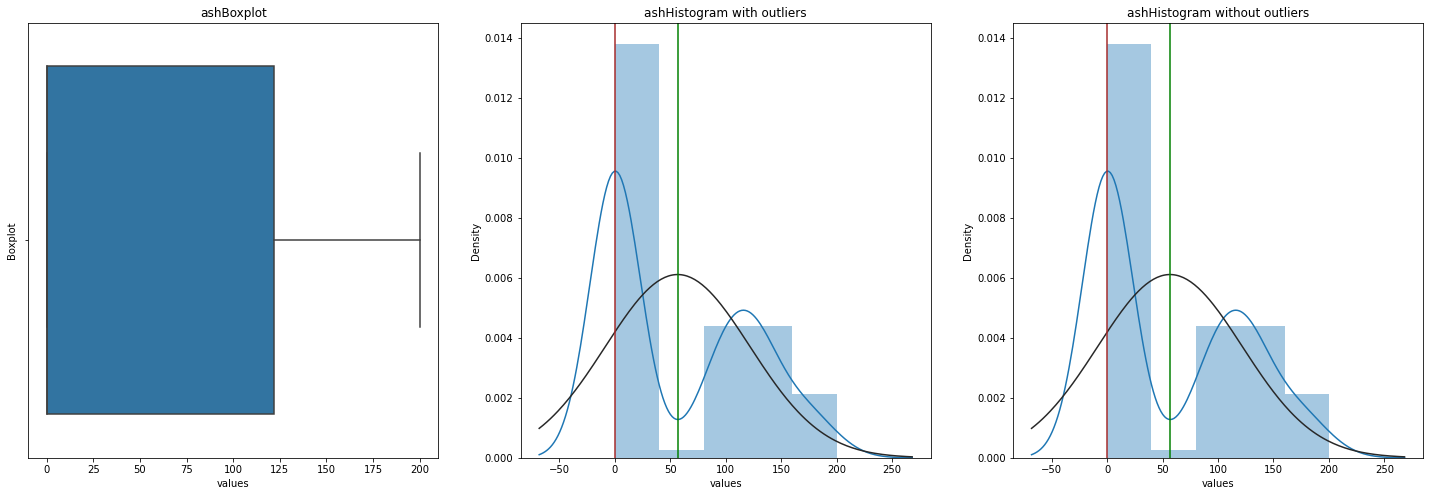

Feature water doesnot have any outliers




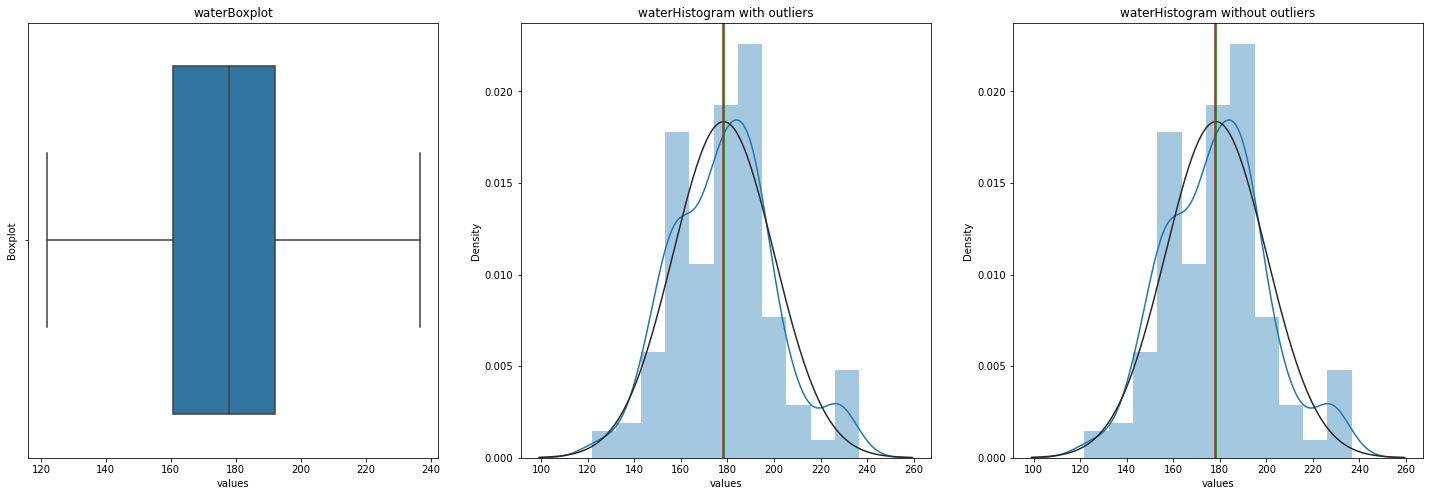

Feature superplastic Has outliers


Total number of outliers in superplastic are 3


outlier percentage in superplastic is 2.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
22,469.0,117.2,0.0,137.8,32.2,852.1,840.5,28
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,56
161,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3


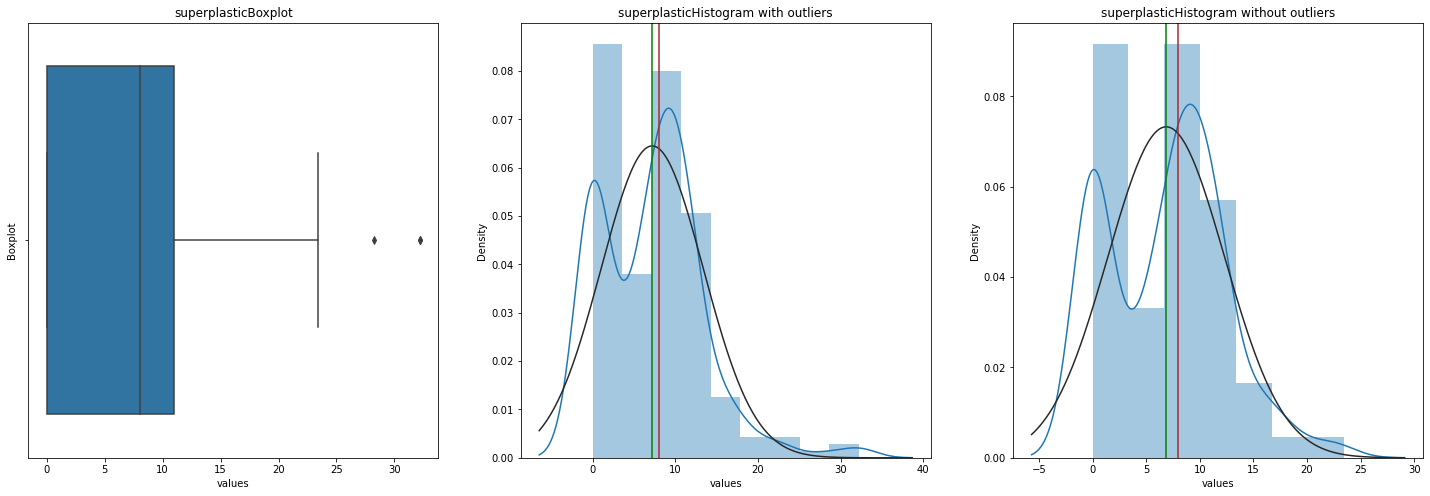

Feature coarseagg doesnot have any outliers




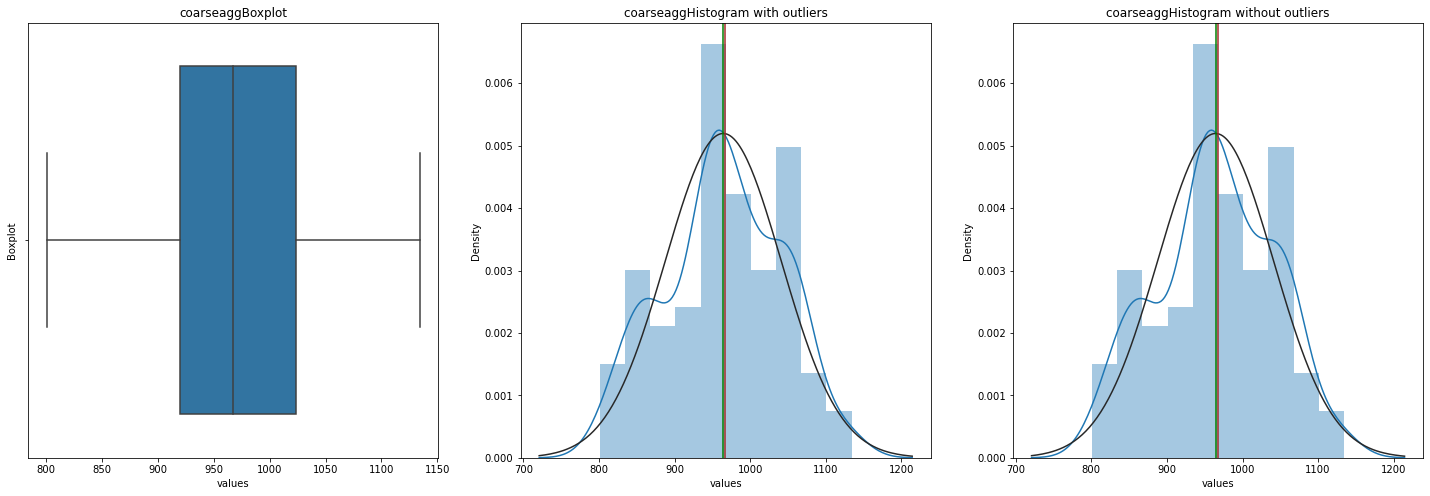

Feature fineagg Has outliers


Total number of outliers in fineagg are 16


outlier percentage in fineagg is 8.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
12,332.5,142.5,0.0,228.0,0.0,932.0,594.0,28
13,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28
23,154.0,174.0,185.0,228.0,7.0,845.0,612.0,28
47,313.3,262.2,0.0,175.5,8.6,1046.9,611.8,3
48,332.5,142.5,0.0,228.0,0.0,932.0,594.0,7
56,427.5,47.5,0.0,228.0,0.0,932.0,594.0,270
63,375.0,93.8,0.0,126.6,23.4,852.1,992.6,28
84,237.5,237.5,0.0,228.0,0.0,932.0,594.0,270
91,500.1,0.0,0.0,200.0,3.0,1124.4,613.2,28
97,313.3,262.2,0.0,175.5,8.6,1046.9,611.8,91


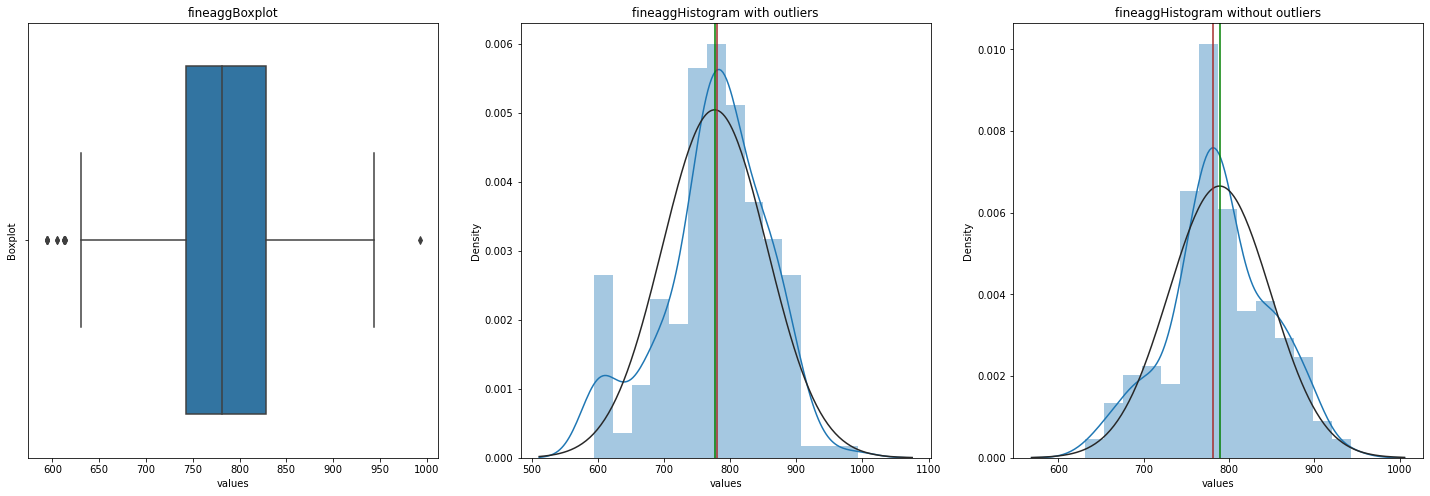

Feature age Has outliers


Total number of outliers in age are 31


outlier percentage in age is 16.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
7,297.2,0.0,117.5,174.8,9.5,1022.8,753.5,100
40,337.9,189.0,0.0,174.9,9.5,944.7,755.8,91
42,212.0,0.0,124.8,159.0,7.8,1085.4,799.5,100
56,427.5,47.5,0.0,228.0,0.0,932.0,780.7,270
64,218.2,54.6,123.8,140.8,11.9,1075.7,792.7,100
67,310.0,0.0,0.0,192.0,0.0,970.0,850.0,180
68,310.0,0.0,0.0,192.0,0.0,1012.0,830.0,120
70,213.7,98.1,24.5,181.7,6.9,1065.8,785.4,100
78,212.1,0.0,121.6,180.3,5.7,1057.6,779.3,100
84,237.5,237.5,0.0,228.0,0.0,932.0,780.7,270


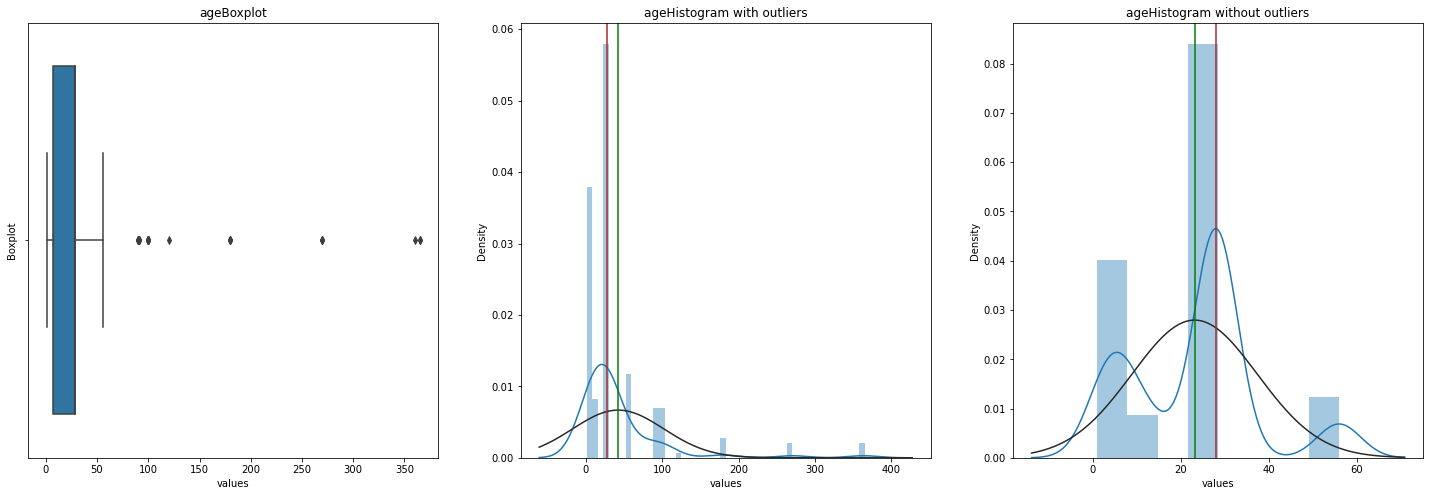

In [41]:
for col in df.columns:
    odt_plots(df, col)

In [42]:
predicted_values = model.predict(df)

In [43]:
predicted_values

array([14.55986214, 14.90704882, 23.19397652, 13.71547974, 10.71059611,
       32.89318743, 24.87404324, 39.23185105, 26.19718106, 40.22960266,
       33.75210585, 42.17848662, 43.87514605, 45.77647964, 40.37125251,
        8.90002692, 29.21550897, 55.20668622, 22.21886516, 18.56635267,
       36.91332483, 35.29159304, 68.6321136 , 26.53950445, 22.87291973,
       32.49527841, 26.03052182, 17.92583302, 24.99277057, 48.04625249,
       47.73692802, 36.17127108, 32.17286553, 37.49181882, 53.59196678,
       22.57762918, 48.6676202 ,  9.83039524, 24.42751812, 57.66114323,
       57.54327484, 27.36981848, 28.76506077, 39.58660497, 68.56845549,
       42.80115463, 27.91138663, 29.68427785, 26.75282217, 16.05203521,
       30.0765854 , 45.46713814, 29.90577029,  9.51163906, 52.31458965,
       14.31320423, 45.43822927, 17.61610387, 28.30897621, 29.99858976,
       29.43751813, 35.60859957, 50.18610302, 58.49072096, 47.90729413,
       28.94611312, 34.51382922, 30.22429946, 30.55100162, 69.57

In [44]:
import csv

def save_values_to_csv(values, filename):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Predicted Values'])  # Optional: Add a header row
        writer.writerows([[value] for value in values])

# Example usage:
predicted_values = model.predict(df)
save_values_to_csv(predicted_values, 'predicted_values.csv')